# Learning to Rank

![](https://blog.griddynamics.com/content/images/2020/03/img-3-1.jpg)

**Imports**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import shap

plt.style.use('seaborn')

## What is Ranking ?

Ranking of query is one of the fundamental problems in information retrieval (IR), the scientific/engineering discipline behind search engines. 

Given a query $q$ and a collection $D$ of documents that match the query, the problem is to rank, that is, sort, the documents in $D$ according to some criterion so that the "best" results appear early in the result list displayed to the user. 

Ranking in terms of information retrieval is an important concept in computer science and is used in many different applications such as search engine queries and recommender systems. 

A majority of search engines use ranking algorithms to provide users with accurate and relevant results.

***Applications of Ranking:***
- Information Retrieval
- Collaborative Filtering
- Automated Text Scoring (Essay Scoring)
- Machine Translation
- Sentence Parsing

**Learning to Rank**

>Learning to rank or machine-learned ranking (MLR) is the application of machine learning, typically supervised, semi-supervised or reinforcement learning, in the construction of ranking models for information retrieval systems. Training data consists of lists of items with some partial order specified between items in each list. This order is typically induced by giving a numerical or ordinal score or a binary judgment (e.g. "relevant" or "not relevant") for each item. The ranking model purposes to rank, i.e. producing a permutation of items in new, unseen lists in a similar way to rankings in the training data.

## Supervised Ranking

### Pointwise model

Pointwise approaches look at a single document at a time in the loss function. They essentially take a single document and train a classifier / regressor on it to predict how relevant it is for the current query. The final ranking is achieved by simply sorting the result list by these document scores. For pointwise approaches, the score for each document is independent of the other documents that are in the result list for the query.
All the standard regression and classification algorithms can be directly used for pointwise learning to rank.

Regression, Classification, Ordinal regression (items to be ranked are treated in isolation)

Scenario:
We have customers searching for different movies and those have been ranked by a customer relevance score

In [91]:
size = 1000
movie_genere = ['Action','Adventure','Animation','Children’s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

movies = pd.DataFrame({
    'customer_id': np.random.choice(['c1','c2','c3','c4','c5'],size=size),
    'movie': [ f'movie_{x+1}' for x in range(size)],
    'genere': np.random.choice(movie_genere,size=size),
    'price': np.random.gamma(50,size=size) * np.random.uniform(0.0,1.0,size=size),
    'rating': np.random.randint(1,100,size=size)  * np.random.uniform(0.0,1.0,size=size),
})

for gnr in movie_genere:
    mean_price = movies.loc[movies.genere == gnr,'price'].mean()
    mean_rating = movies.loc[movies.genere == gnr,'rating'].mean()
    movies.loc[(movies.genere == gnr) & (movies.price < mean_price ) & (movies.rating > mean_rating),'relevance'] = 1

movies.loc[movies.relevance != 1, 'relevance'] = 0
movies

,customer_id,movie,genere,price,rating,relevance
0,c4,movie_1,Animation,36.875232,0.109586,0.0
1,c2,movie_2,Horror,14.994330,29.543855,1.0
2,c2,movie_3,Crime,18.350202,24.308950,0.0
3,c5,movie_4,Children’s,36.660083,15.435363,0.0
4,c1,movie_5,Comedy,14.498468,3.320721,0.0
...,...,...,...,...,...,...
995,c4,movie_996,Comedy,38.772438,59.713921,0.0
996,c3,movie_997,Thriller,36.178473,11.326334,0.0
997,c4,movie_998,Adventure,21.479971,43.585153,1.0
998,c1,movie_999,War,28.659169,0.708221,0.0


Now that we have the data we can define the features we will use in our model and the target variable

In [92]:
features = ['genere','price','rating']
target = 'relevance'

Since we have a categorical variable we will dumify the data

In [93]:
movies_processed = movies.copy()
movies_processed = pd.get_dummies(movies_processed[features + [target]])

then we can train/test split our dataset

In [94]:
train,test = train_test_split(movies_processed, test_size=0.33, random_state=42, stratify=movies[['genere','relevance']])

so now we can train our classifier to predict how relevant is a movie for a customer

In [95]:
clf = LogisticRegression()
clf.fit(train.drop([target],axis=1),train[target])

LogisticRegression()

let's take a copy of our test dataframe and apply the model

In [96]:
val = test.copy().reset_index(drop=True)

val['y_pred'] = clf.predict(test.drop([target],axis=1))
val['y_pred_proba'] = clf.predict_proba(test.drop([target],axis=1))[:,1]

val[:3]

,price,rating,relevance,genere_Action,genere_Adventure,genere_Animation,genere_Children’s,genere_Comedy,genere_Crime,genere_Documentary,...,genere_Horror,genere_Musical,genere_Mystery,genere_Romance,genere_Sci-Fi,genere_Thriller,genere_War,genere_Western,y_pred,y_pred_proba
0,44.963785,45.100109,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0.0,0.002454
1,21.442252,35.388441,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.0,0.128310
2,30.280563,26.777554,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.0,0.010166


**We use the Compute Normalized Discounted Cumulative Gain(NDCG) to assess our model**

Sum the true scores ranked in the order induced by the predicted scores, after applying a logarithmic discount. 

Then divide by the best possible score (Ideal DCG, obtained for a perfect ranking) to obtain a score between 0 and 1.

In [97]:
metrics.ndcg_score([val[target]],[val['y_pred']])

0.9131585064991307

### Pairwise model

Pairwise approaches look at a pair of documents at a time in the loss function. Given a pair of documents, they try and come up with the optimal ordering for that pair and compare it to the ground truth. The goal for the ranker is to minimize the number of inversions in ranking i.e. cases where the pair of results are in the wrong order relative to the ground truth.
Pairwise approaches work better in practice than pointwise approaches because predicting relative order is closer to the nature of ranking than predicting class label or relevance score. Some of the most popular Learning to Rank algorithms like RankNet, LambdaRank and LambdaMART are pairwise approaches.

Rank-preference models (items to be ranked are treated in pairs)

Scenario:
We have a lot of papers and we some very defined queries - we want to find the most relevant documents given the query

In [9]:
docs_size = 1000
query_types = ['query_1','query_2','query_3','query_4','query_5']

docs = pd.DataFrame({
    'qid': np.random.choice(query_types,size=docs_size),
    'did': [ f'doc_{x+1}' for x in range(docs_size)],
    'doc_size': np.random.uniform(1,500,size=docs_size),
    'doc_authors': np.random.randint(2,6,size=docs_size),
    'doc_paragraphs': np.random.randint(50,200,size=docs_size),
    'relevance': np.random.uniform(0.0,1.0,size=docs_size)
})

docs['rank'] = pd.cut(docs['relevance'],5,labels=list(range(1,6)))
docs = docs.sort_values(by='rank')
docs

,qid,did,doc_size,doc_authors,doc_paragraphs,relevance,rank
499,query_1,doc_500,134.883309,5,127,0.094079,1
728,query_4,doc_729,43.758156,3,79,0.090593,1
727,query_2,doc_728,246.796883,3,101,0.147661,1
718,query_3,doc_719,348.961423,4,82,0.116877,1
715,query_3,doc_716,226.646396,4,146,0.157098,1
...,...,...,...,...,...,...,...
548,query_4,doc_549,15.807793,3,134,0.959892,5
835,query_4,doc_836,178.380919,5,112,0.829741,5
103,query_5,doc_104,215.429695,2,89,0.802579,5
113,query_5,doc_114,158.357579,5,136,0.891533,5


again we define the features we are going to use in our models

In [11]:
docs_feats = ['doc_size','doc_authors','doc_paragraphs']
docs_target = 'rank'

We train test split the data, but also sort it by the rank we have assigned

In [10]:
docs_train, docs_test = train_test_split(docs, test_size=0.33, random_state=42)

docs_train = docs_train.sort_values(by='rank')
docs_test = docs_test.sort_values(by='rank')

in the next models we need to specify the number of samples related to group/query/domain

In [12]:
groups = docs_train.groupby('qid').size().to_frame('size')['size'].to_numpy()

>Actually, in Learning to Rank field, we are trying to predict the relative score for each document to a specific query. 
That is, this is not a regression problem or classification problem. Hence, if a document, attached to a query, gets a negative predict score, it means and only means that it's relatively less relative to the query, when comparing to other document(s), with positive scores.

Then we can train our XGBoost model using the `Pairwise` objective

In [99]:
ranker = xgb.XGBRanker(objective='rank:pairwise',booster='gbtree')
ranker.fit(docs_train[docs_feats],docs_train['rank'],group=groups)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.300000012, max_delta_step=0, max_depth=6,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method='exact', validate_parameters=1, verbosity=None)

and predict the rank score using our model

In [103]:
results = docs_test.copy()
results['rank_score_pairwise'] = ranker.predict(results[docs_feats])    
results = results.sort_values(by='rank_score_pairwise',ascending=False)
results

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,qid,did,doc_size,doc_authors,doc_paragraphs,relevance,rank,rank_score_pairwise
131,query_5,doc_132,438.245360,5,131,0.468934,3,5.788270
837,query_5,doc_838,491.327195,3,126,0.271177,2,5.774170
815,query_2,doc_816,38.272288,5,145,0.644796,4,5.751684
202,query_4,doc_203,120.329668,3,130,0.575423,3,5.630410
246,query_4,doc_247,421.376384,3,176,0.056486,1,5.495399
...,...,...,...,...,...,...,...,...
419,query_4,doc_420,358.623323,3,56,0.489202,3,-2.377359
917,query_5,doc_918,13.784377,3,75,0.943996,5,-2.487809
748,query_2,doc_749,497.286684,3,55,0.904371,5,-3.127292
282,query_4,doc_283,463.882003,3,57,0.680035,4,-3.233275


We are using again the NDCG score to see how our model performs

In [104]:
metrics.ndcg_score([results['rank']],[results['rank_score_pairwise']])

0.8948626084762222

In [105]:
results.sort_values(by=['qid','rank_score_pairwise'],ascending=False)

,qid,did,doc_size,doc_authors,doc_paragraphs,relevance,rank,rank_score_pairwise
131,query_5,doc_132,438.245360,5,131,0.468934,3,5.788270
837,query_5,doc_838,491.327195,3,126,0.271177,2,5.774170
705,query_5,doc_706,463.690276,3,125,0.634287,4,5.332096
160,query_5,doc_161,48.579709,2,136,0.555408,3,4.670428
890,query_5,doc_891,202.299155,2,108,0.814885,5,4.618782
...,...,...,...,...,...,...,...,...
808,query_1,doc_809,424.648466,5,71,0.006189,1,-0.325586
850,query_1,doc_851,402.305516,4,68,0.554643,3,-0.591345
31,query_1,doc_32,470.012134,2,67,0.459052,3,-0.765779
857,query_1,doc_858,158.421303,2,177,0.703012,4,-1.140166


### Listwise model

Listwise approaches directly look at the entire list of documents and try to come up with the optimal ordering for it. 

There are 2 main sub-techniques for doing listwise Learning to Rank:
- Direct optimization of IR measures such as NDCG. E.g. SoftRank , AdaRank
- Minimize a loss function that is defined based on understanding the unique properties of the kind of ranking you are trying to achieve. E.g. ListNet , ListMLE

Treat each list as an instance. Usually tries to directly optimise the evaluation measure (e.g. mean average precision)

Using the same data as above we can train another model but this time using the `NDCG` objective

In [111]:
ranker = xgb.XGBRanker(objective='rank:ndcg',booster='gbtree')
ranker.fit(docs_train[docs_feats],docs_train['rank'],group=groups)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.300000012, max_delta_step=0, max_depth=6,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=100, n_jobs=32, num_parallel_tree=1,
          objective='rank:ndcg', random_state=0, reg_alpha=0, reg_lambda=1,
          scale_pos_weight=None, subsample=1, tree_method='exact',
          validate_parameters=1, verbosity=None)

and predict the ranking score using this model as well

In [112]:
results['rank_score_ndcg'] = ranker.predict(results[docs_feats])    
results = results.sort_values(by='rank_score_ndcg',ascending=False)
results

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


,qid,did,doc_size,doc_authors,doc_paragraphs,relevance,rank,rank_score_pairwise,rank_score_ndcg
131,query_5,doc_132,438.245360,5,131,0.468934,3,5.788270,0.564546
100,query_4,doc_101,311.435717,4,115,0.777631,4,0.721314,0.564546
460,query_3,doc_461,339.116520,4,173,0.327702,2,3.660527,0.564546
705,query_5,doc_706,463.690276,3,125,0.634287,4,5.332096,0.564546
134,query_2,doc_135,422.214211,4,170,0.902875,5,4.722393,0.564546
...,...,...,...,...,...,...,...,...,...
421,query_5,doc_422,131.493036,2,69,0.524366,3,3.481098,0.432135
194,query_4,doc_195,86.266093,2,102,0.499842,3,4.688314,0.432135
5,query_1,doc_6,154.925980,4,94,0.500868,3,1.975777,0.432135
663,query_3,doc_664,139.543270,5,61,0.438917,3,3.006506,0.432135


We are using again the NDCG score to see how our model performs

In [113]:
metrics.ndcg_score([results['rank']],[results['rank_score_ndcg']])

0.8841611992803472

In [114]:
results.sort_values(by=['qid','rank_score_ndcg'],ascending=False)

,qid,did,doc_size,doc_authors,doc_paragraphs,relevance,rank,rank_score_pairwise,rank_score_ndcg
131,query_5,doc_132,438.245360,5,131,0.468934,3,5.788270,0.564546
705,query_5,doc_706,463.690276,3,125,0.634287,4,5.332096,0.564546
647,query_5,doc_648,499.702704,5,112,0.640742,4,3.949763,0.564546
37,query_5,doc_38,446.435847,2,139,0.078024,1,1.788967,0.564546
372,query_5,doc_373,376.365562,4,118,0.256528,2,1.769992,0.564546
...,...,...,...,...,...,...,...,...,...
412,query_1,doc_413,146.237719,3,101,0.505013,3,3.511979,0.432135
593,query_1,doc_594,51.742807,5,50,0.408177,3,2.817086,0.432135
174,query_1,doc_175,152.116111,4,103,0.077273,1,2.433534,0.432135
518,query_1,doc_519,116.540539,5,103,0.418459,3,4.447410,0.432135


## Expedia Hotel Recommendation

![](https://cdn.geekwire.com/wp-content/uploads/2016/05/20160511_Expedia_08-630x420.jpg)

Expedia has provided you [logs of customer behavior](https://www.kaggle.com/c/expedia-hotel-recommendations/data). These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

| Column name               | Description                                                                                                               | Data type |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------|-----------|
| date_time                 | Timestamp                                                                                                                 | string    |
| site_name                 | ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)                                     | int       |
| posa_continent            | ID of continent associated with site_name                                                                                 | int       |
| user_location_country     | The ID of the country the customer is located                                                                             | int       |
| user_location_region      | The ID of the region the customer is located                                                                              | int       |
| user_location_city        | The ID of the city the customer is located                                                                                | int       |
| orig_destination_distance | Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated | double    |
| user_id                   | ID of user                                                                                                                | int       |
| is_mobile                 | 1 when a user connected from a mobile device, 0 otherwise                                                                 | tinyint   |
| is_package                | 1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise                    | int       |
| channel                   | ID of a marketing channel                                                                                                 | int       |
| srch_ci                   | Checkin date                                                                                                              | string    |
| srch_co                   | Checkout date                                                                                                             | string    |
| srch_adults_cnt           | The number of adults specified in the hotel room                                                                          | int       |
| srch_children_cnt         | The number of (extra occupancy) children specified in the hotel room                                                      | int       |
| srch_rm_cnt               | The number of hotel rooms specified in the search                                                                         | int       |
| srch_destination_id       | ID of the destination where the hotel search was performed                                                                | int       |
| srch_destination_type_id  | Type of destination                                                                                                       | int       |
| hotel_continent           | Hotel continent                                                                                                           | int       |
| hotel_country             | Hotel country                                                                                                             | int       |
| hotel_market              | Hotel market                                                                                                              | int       |
| is_booking                | 1 if a booking, 0 if a click                                                                                              | tinyint   |
| cnt                       | Numer of similar events in the context of the same user session                                                           | bigint    |
| hotel_cluster             | ID of a hotel cluster                                                                                                     | int       |

In [115]:
expedia = pd.read_csv('data/expedia-hotel-recommendations/train.csv')[:200000].copy()
expedia.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


## Modeling

Our objective here is to predict a list of hotel clusters for each user.

But first let's make a list of features and a variable for target and group_id

we use group_id to define the column that will count the number of samples related to a group/query/domain

In [116]:
features = [
    'site_name','posa_continent','user_location_country','user_location_region', 'user_location_city',
    'orig_destination_distance', 'is_mobile', 'is_package','channel', 'srch_adults_cnt', 'srch_children_cnt',
    'srch_rm_cnt', 'srch_destination_type_id','is_booking', 'cnt', 'hotel_continent', 'hotel_country', 
    'hotel_market', 'srch_days', 'srch_ci_month'
]
group_id = 'user_id'
target = 'hotel_cluster'

we use this fuction for feature engineering
- we want to take the number of the mount from the check in search date
- we want to extract the number of days the user is looking to book

In [119]:
def my_feature_engineering(df):
    data = df.copy()
    for c in ['srch_ci','srch_co']:
        data[c] = pd.to_datetime(data[c])
        data[f'{c}_month'] = data[c].dt.month
        
    data['srch_days'] = (data['srch_co'] - data['srch_ci']).dt.days    
    return data

we apply the feature engineering function

In [120]:
expedia = my_feature_engineering(expedia)

after that we can train/test split our data

In [121]:
train,test = train_test_split(expedia, test_size=0.33, random_state=42)

then we want to get the number of samples by our group_id column in this case is the `used_id` column

Note: the sum of the number of groups must match the size of the training set

In [122]:
train_groups = train.groupby(group_id).size()

In [123]:
len(train_groups)

6773

finally we can train our ranking model

In [124]:
ranker = xgb.XGBRanker(objective='rank:ndcg',booster='gbtree')
ranker.fit(train[features], train[target], group=train_groups)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.300000012, max_delta_step=0, max_depth=6,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=100, n_jobs=32, num_parallel_tree=1,
          objective='rank:ndcg', random_state=0, reg_alpha=0, reg_lambda=1,
          scale_pos_weight=None, subsample=1, tree_method='exact',
          validate_parameters=1, verbosity=None)

Now that we've trained our model we can take a copy of our test data and apply the model.

Then we predict the relevance score for each group in our dataframe.

In [125]:
%%capture
results = test.copy()
results['rank_score_ndcg'] = ranker.predict(results[features])       
results = results.sort_values(by='rank_score_ndcg',ascending=False)

In [126]:
results[:5]

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,srch_ci_month,srch_co_month,srch_days,rank_score_ndcg
11832,2014-12-03 23:07:59,2,3,66,174,5013,4134.9107,65362,1,1,...,0,5,0,140,59,92,3.0,3.0,3.0,2.776571
57880,2013-03-02 17:59:35,2,3,66,318,7412,6007.6063,202006,1,1,...,0,2,0,140,59,92,1.0,1.0,6.0,2.745670
165013,2013-03-18 23:49:34,30,4,195,995,55763,NaN,623285,0,0,...,0,4,0,63,1108,49,5.0,5.0,3.0,2.699138
165016,2013-03-18 23:55:09,30,4,195,995,55763,NaN,623285,0,0,...,0,1,0,63,1108,59,5.0,5.0,1.0,2.597546
14238,2014-01-08 14:19:07,13,1,46,171,56407,8597.2618,72327,0,1,...,0,1,0,63,1193,2,3.0,3.0,1.0,2.582656


Again we use the NDCG score to see how our model performs

In [127]:
metrics.ndcg_score([results[target]],[results['rank_score_ndcg']])

0.9546739271914936

Now let's look at the feature importance and impact

In [128]:
expl = shap.TreeExplainer(ranker)
shap_values = expl.shap_values(test[features])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


At first glance we can see:
- a low value/category for hotel_continent is increasing the relevance score where a high value is decreasing it
- on the other hand a high value/category for user location region is increasing the score and the reverse of it when the feature value is low
- many features have a contradictoy impact whre a high value is having a both negative and positive imapct toward the model output

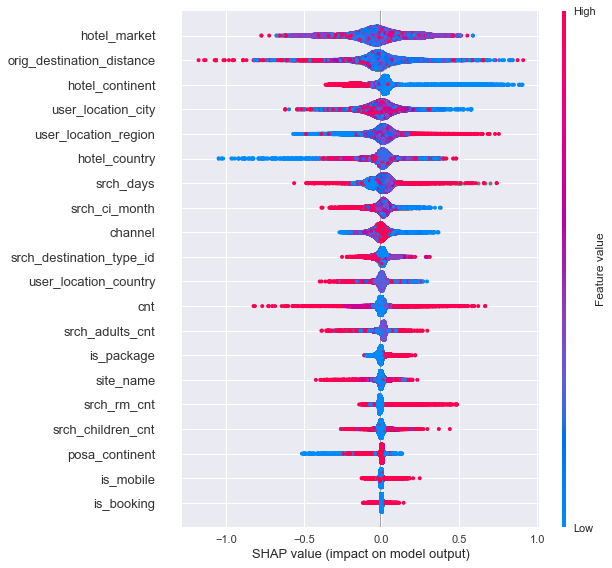

In [129]:
shap.summary_plot(shap_values,test[features])

## Conclusions

- Learning to rank is another subranch of machine learning focused on ranking and usaully used in Informatio Retrieval(IR)
- Very large datasets are used in training the models in this area, but in the same time filtering capabilities are serving an important role
- Framing the problem right give `data` and `goal` is an essential part for solving ranking problem

## References

- [Tiered machine learned ranking improves relevance for the retail search](https://blog.griddynamics.com/tiered-machine-learning-ranking-improves-relevance-for-the-retail-search/)
- [Learning to Rank](https://www.cl.cam.ac.uk/teaching/1516/R222/l2r-overview.pdf)
- [learning-to-rank-1](https://dec0de.me/2014/10/learning-to-rank-1)
- [Learning to Rank with Partially-Labeled Data](http://www.cs.jhu.edu/~kevinduh/papers/duh08sigir.pdf)
- [Learning to Rank with XGBoost and GPU](https://developer.nvidia.com/blog/learning-to-rank-with-xgboost-and-gpu/)
- [Ranking Ads with Machine Learning](https://tech.olx.com/ranking-ads-with-machine-learning-ee03d7734bf4)
- [How we’ve reworked our listings at OLX](https://medium.com/@pablopallocchi/how-weve-reworked-our-listings-at-olx-b6a6c05be8b5)
- [Notes on the NDCG metric used in the Visual Dialog Challenge 2019](https://medium.com/@_init_/notes-on-the-ndcg-metric-used-in-the-visual-dialog-challenge-2019-90cf443b93dc)
- [Learning to Rank with Partially-Labeled Data](http://www.cs.jhu.edu/~kevinduh/papers/duh08sigir.pdf)